# CNN for Image Classification using PyTorch

In this lesson, we will build a convolutional neural network (CNN) for image classification. Our dataset consists of JPEG files organized in folders where the folder name represents the class label (e.g., `collet`, `miter_gear`). All folders are located in `data/fabwave` and each folder contains 10 images (this is just for practice; in real world cases, we tend to use far more data).

We will:
- Use data loaders with data augmentation to load images of different resolutions.
- Define and train a CNN model while tracking error and accuracy over epochs.
- Use a separate `test_cases` folder to predict on new images and plot the image along with its predicted label.

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Preparation and Augmentation

We define our transforms for both training and validation. Data augmentation techniques (like random horizontal flips and random rotations) are applied to help improve the model's robustness given the small dataset size.

In [2]:
# Define transformations for the training data
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # resize all images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For validation/testing, no augmentation
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Loading the Dataset

We use `ImageFolder` to load images from `data/fabwave`, where each subfolder is treated as a class label.

Classes: ['bolt', 'collet', 'idler_sprocket', 'miter_gear', 'strut_floor_mount', 'test_cases']


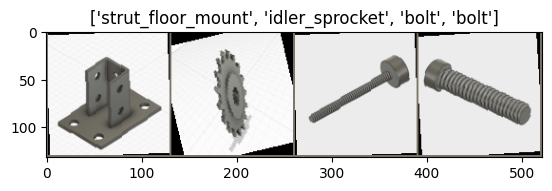

In [5]:
# Path to the dataset
# data_dir = '../data/fabwave'
data_dir = './data/fabwave'

# Load dataset with training transforms
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
class_names = dataset.classes
print(f"Classes: {class_names}")

# Create data loader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Visualize some training images
def imshow(inp, title=None):
    # Convert tensor to numpy - transpose (Channels, Height, Width) to (H, W, C)
    inp = inp.numpy().transpose((1, 2, 0))
    # Un-normalize from normalized_pixel_value = (original_pixel_value - mean) / std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # ensures all pixel value are between 0 and 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Define the CNN Model

We define a simple CNN architecture with a couple of convolutional and pooling layers, followed by fully connected layers.

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * 32 * 32, 128),  # assuming input images are 128x128
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate model
num_classes = len(class_names)
model = SimpleCNN(num_classes=num_classes).to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


## Define Loss Function and Optimizer

We use cross-entropy loss and the Adam optimizer.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the Model

We train the model over a set number of epochs and track both the training loss (error) and accuracy at each epoch.

In [8]:
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print('Training complete')

Epoch 1/10 Loss: 2.0957 Acc: 0.2909
Epoch 2/10 Loss: 1.5582 Acc: 0.4545
Epoch 3/10 Loss: 1.2967 Acc: 0.5455
Epoch 4/10 Loss: 0.8323 Acc: 0.7636
Epoch 5/10 Loss: 0.5898 Acc: 0.8727
Epoch 6/10 Loss: 0.4923 Acc: 0.9091
Epoch 7/10 Loss: 0.6997 Acc: 0.8000
Epoch 8/10 Loss: 0.5170 Acc: 0.9091
Epoch 9/10 Loss: 0.4042 Acc: 0.8909
Epoch 10/10 Loss: 0.6595 Acc: 0.9091
Training complete


## Plotting Training Loss and Accuracy

We now plot the error (loss) and accuracy over the training epochs.

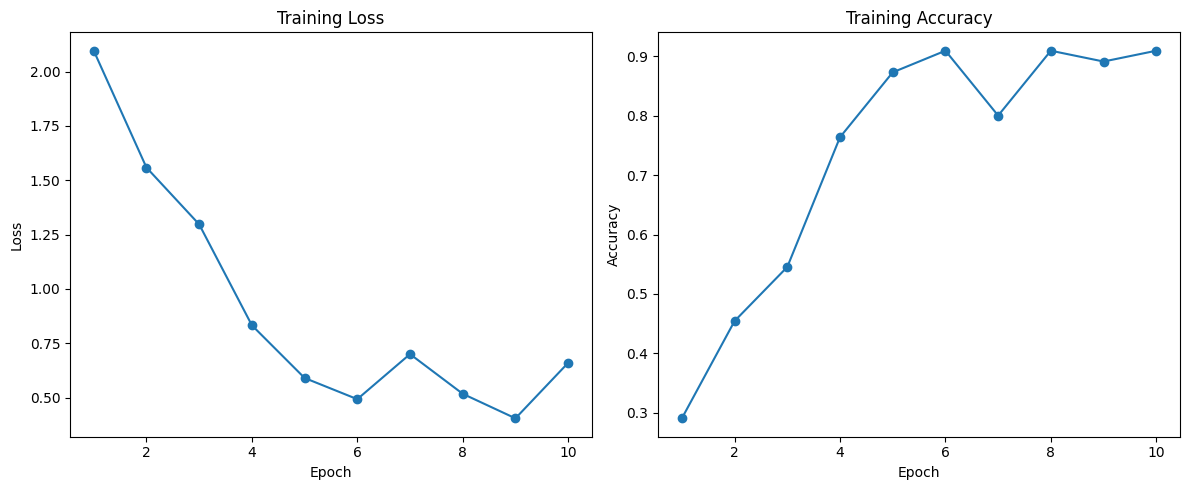

In [9]:
plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## Testing on New Images

We load images from the `test_cases` folder, predict their class using our trained model, and plot each image with its predicted label.

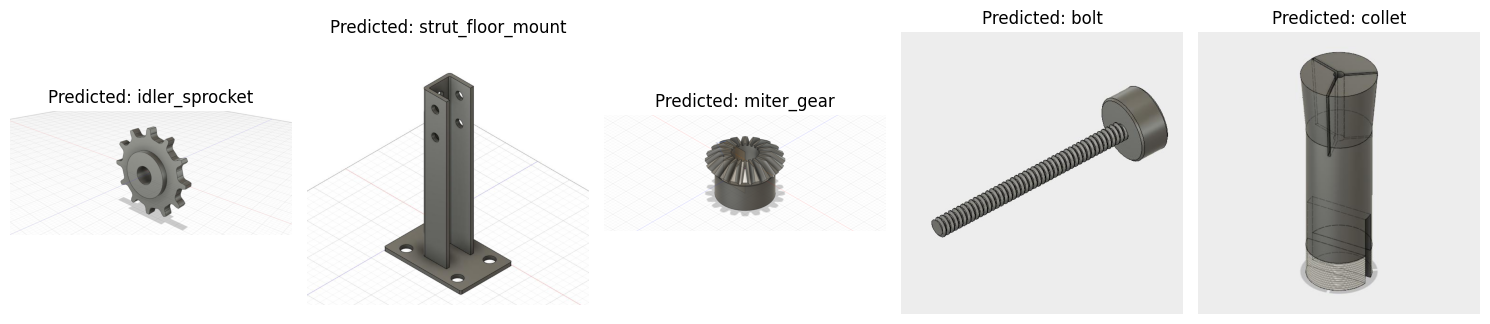

In [11]:
import glob

# test_folder = '../data/fabwave/test_cases'
test_folder = './data/fabwave/test_cases'
test_image_paths = glob.glob(os.path.join(test_folder, '*'))

model.eval()
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(test_image_paths):
    # Open image and apply test transforms
    image = Image.open(image_path).convert('RGB')
    input_img = test_transforms(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_img)
        _, pred = torch.max(outputs, 1)
        predicted_label = class_names[pred.item()]
    
    # Plot the image with the predicted label
    plt.subplot(1, len(test_image_paths), i+1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()